# Calculate Equilibrium Climate Sensitivity for CMIP6 data using Gregory regression
## Goal: Use Gregory regression to calculate ECS $\Delta T$ [Gregory et al 2004](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003GL018747) 

### Using CESM2 from the CMIP analysis platform repository on glade

In [1]:
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats

plt.rcParams['figure.figsize'] = (8,5)

### Open the surface temperature file for abrupt4xCO2

In [2]:
var="ts"
file="/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/"+var+"/gn/latest/"+var+"_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc"

In [3]:
ds = xr.open_dataset(file)

### Get the cell area to calculate the area weights

In [4]:
areads = xr.open_dataset("/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/fx/areacella/gn/latest/areacella_fx_CESM2_abrupt-4xCO2_r1i1p1f1_gn.nc")
weight=areads.areacella / areads.areacella.sum(dim=('lon','lat'))
weight.sum(dim=('lon','lat'))

<xarray.DataArray 'areacella' ()>
array(1., dtype=float32)

### Calculate the global mean

In [5]:
tsGm=(np.tile(weight,[len(ds.time),1,1])*ds.ts).sum(dim=('lat','lon'))

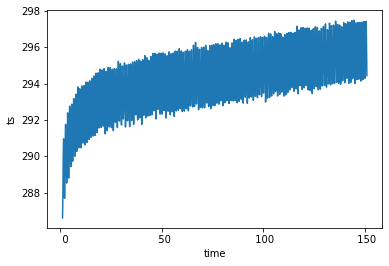

In [6]:
tsGm.plot()

### Calculate the annual mean

In [7]:
tsGm_annual = tsGm.resample(time='A',label='left',loffset='6M').mean(dim='time')

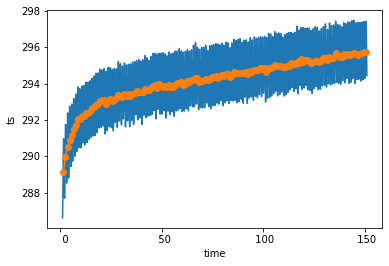

In [8]:
tsGm.plot()
tsGm_annual.plot(marker='o')

### Get and calculate net TOA fluxes

In [9]:
# OLR
var="rlut"
filep="/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/"+var+"/gn/latest/"+var+"_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc"
dsp = xr.open_dataset(filep)
olrGm=(np.tile(weight,[len(dsp.time),1,1])*dsp.rlut).sum(dim=('lat','lon'))

In [10]:
# SW d
var="rsdt"
filep="/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/"+var+"/gn/latest/"+var+"_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc"
dsp = xr.open_dataset(filep)
swdGm=(np.tile(weight,[len(dsp.time),1,1])*dsp.rsdt).sum(dim=('lat','lon'))


In [11]:
# SW u
var="rsut"
filep="/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/"+var+"/gn/latest/"+var+"_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc"
dsp = xr.open_dataset(filep)
swuGm=(np.tile(weight,[len(dsp.time),1,1])*dsp.rsut).sum(dim=('lat','lon'))


In [12]:
olrGm_annual = olrGm.resample(time='A',label='left',loffset='6M').mean(dim='time')
swdGm_annual = swdGm.resample(time='A',label='left',loffset='6M').mean(dim='time')
swuGm_annual = swuGm.resample(time='A',label='left',loffset='6M').mean(dim='time')


In [13]:
N = swdGm_annual - swuGm_annual - olrGm_annual

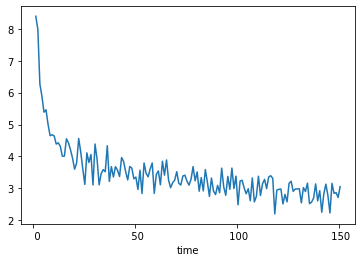

In [14]:
N.plot()

Text(0.5, 1.0, 'CESM2')

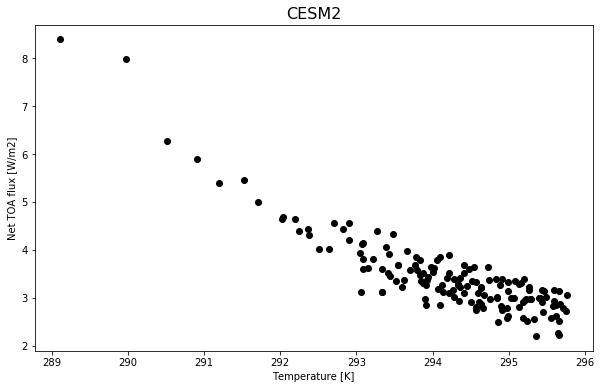

In [15]:
# Create a figure
fig = plt.figure(figsize=(10, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(tsGm_annual,N,marker='o',linestyle='None',color='k')
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Net TOA flux [W/m2]')
ax.set_title('CESM2', fontdict={'size':16})

### Now get the baseline data from the preindustrial control sims

In [16]:
experiment='piControl'
var="ts"
ds_ts_pi_all = xr.open_mfdataset("/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/"+experiment+"/r1i1p1f1/Amon/"+var+"/gn/latest/"+var+"_Amon_CESM2_"+experiment+"_r1i1p1f1_gn_*.nc")

In [17]:
endtimes=ds_ts_pi_all.time[-(12*30):]
ts_pi=ds_ts_pi_all.ts.sel(time=slice(endtimes[0],endtimes[-1])).mean(dim=('time'))
ts_pi_gm=(ts_pi*weight).sum(dim=('lat','lon'))
ts_pi_gm.values

array(288.37387, dtype=float32)

In [18]:
experiment='piControl'
var="rlut"
ds_olr_pi_all = xr.open_mfdataset("/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/"+experiment+"/r1i1p1f1/Amon/"+var+"/gn/latest/"+var+"_Amon_CESM2_"+experiment+"_r1i1p1f1_gn_*.nc")


In [19]:
olr_pi=ds_olr_pi_all.rlut.sel(time=slice(endtimes[0],endtimes[-1])).mean(dim=('time'))
olr_pi_gm=(olr_pi*weight).sum(dim=('lat','lon'))
olr_pi_gm.values

array(240.71867, dtype=float32)

In [20]:
var="rsut"
ds_rsut_pi_all = xr.open_mfdataset("/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/"+experiment+"/r1i1p1f1/Amon/"+var+"/gn/latest/"+var+"_Amon_CESM2_"+experiment+"_r1i1p1f1_gn_*.nc")
var="rsdt"
ds_rsdt_pi_all = xr.open_mfdataset("/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/"+experiment+"/r1i1p1f1/Amon/"+var+"/gn/latest/"+var+"_Amon_CESM2_"+experiment+"_r1i1p1f1_gn_*.nc")


In [21]:
rsut_pi=ds_rsut_pi_all.rsut.sel(time=slice(endtimes[0],endtimes[-1])).mean(dim=('time'))
rsut_pi_gm=(rsut_pi*weight).sum(dim=('lat','lon'))
rsut_pi_gm.values

rsdt_pi=ds_rsdt_pi_all.rsdt.sel(time=slice(endtimes[0],endtimes[-1])).mean(dim=('time'))
rsdt_pi_gm=(rsdt_pi*weight).sum(dim=('lat','lon'))
rsdt_pi_gm.values


array(340.24863, dtype=float32)

In [23]:
N_pi = rsdt_pi_gm - rsut_pi_gm - olr_pi_gm
N_pi.values

array(0.6204071, dtype=float32)

Text(0.5, 1.0, 'CESM2')

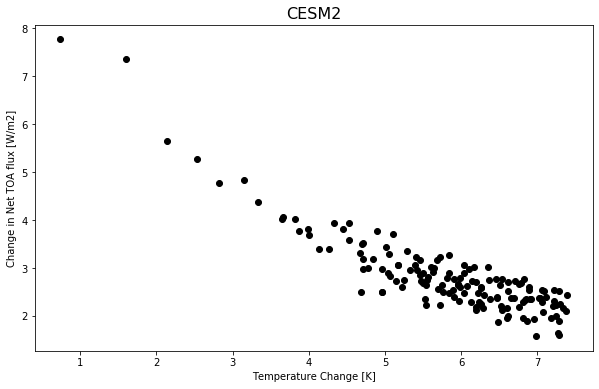

In [24]:
# Create a figure
fig = plt.figure(figsize=(10, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(tsGm_annual-ts_pi_gm,N-N_pi,marker='o',linestyle='None',color='k')
ax.set_xlabel('Temperature Change [K]')
ax.set_ylabel('Change in Net TOA flux [W/m2]')
ax.set_title('CESM2', fontdict={'size':16})

In [25]:
dt = tsGm_annual - ts_pi_gm
dN = N - N_pi

### Add linear regression
Two methods, both from [Jen Kay's class](https://github.com/jenkayco/ATOC7500ObjectiveDataAnalysis/blob/master/ATOC7500_applicationlab2_AR1_regression_AO.ipynb)

In [26]:
### Calculate the correlation statistics - slow way, but convenient
slope, intercept, r_value, p_value, std_err = stats.linregress(dt,dN)
print('scipy.stats.linregress slope: ',round(slope,3))
print('scipy.stats.linregress intercept: ',round(intercept,3))
print('scipy.stats.linregress r_value: ',round(r_value,3))

scipy.stats.linregress slope:  -0.638
scipy.stats.linregress intercept:  6.529
scipy.stats.linregress r_value:  -0.887


In [27]:
# from https://plot.ly/matplotlib/linear-fits/
xi = np.array([0,dt.max()])
line = slope*xi+intercept


In [34]:
ECS = -intercept / slope 
print(ECS)

10.23696515416069


### ECS for 2xCO2, for comparison to 5.3 K

In [36]:
# Assume 2xCO2 F=3.8 W/m2 : NOTE - this is NOT the current standard practice!
ECS2x = -3.8 / slope
print(ECS2x)

5.958504791150195


In [41]:
# Divide 4xCO2 ECS by 2 - this IS the current standard practice!
ECS2x = ECS / 2
print(ECS2x)

5.118482577080345


(0, 8.159161376953126)

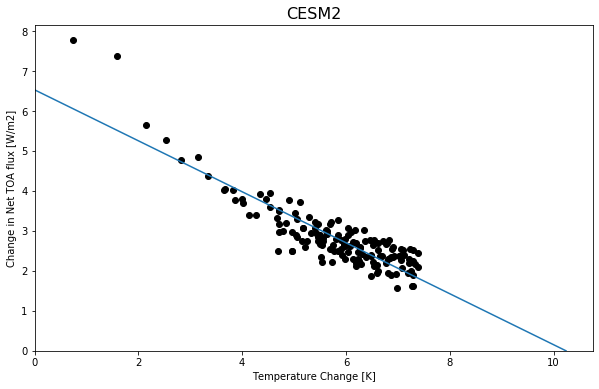

In [38]:
# Create a figure
fig = plt.figure(figsize=(10, 6))

# Ask, out of a 1x1 grid, the first axes.
ax = fig.add_subplot(1, 1, 1)

# Plot times as x-variable and temperatures as y-variable
ax.plot(tsGm_annual-ts_pi_gm,N-N_pi,marker='o',linestyle='None',color='k')
ax.set_xlabel('Temperature Change [K]')
ax.set_ylabel('Change in Net TOA flux [W/m2]')
ax.set_title('CESM2', fontdict={'size':16})

# heres the regression line
plt.plot([0,ECS],[intercept,0])

xlims=plt.xlim()
plt.xlim(0,xlims[1])
ylims=plt.ylim()
plt.ylim(0,ylims[1])

# ECS (to 4xCO2)

In [39]:
ECS

10.23696515416069